Code Initialization

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

env = gym.make("CartPole-v1")
#env = gym.make('Acrobot-v1')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

A glip at the environment

In [2]:
print('Env Reset State:{}, Action Choices:{}, Sample Action:{}'\
      .format(env.reset(), env.action_space, env.action_space.sample()))

print('Sampled Env Return:{}'.format(env.step(env.action_space.sample())))
for i in count():
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    if terminated == True or truncated == True:
        print('Terminated state:{} Truncated state:{} #{}'.format(terminated, truncated, i))
        break

Env Reset State:(array([0.02589558, 0.03720646, 0.02133869, 0.04279843], dtype=float32), {}), Action Choices:Discrete(2), Sample Action:1
Sampled Env Return:(array([ 0.02663971,  0.23201603,  0.02219466, -0.2430763 ], dtype=float32), 1.0, False, False, {})
Terminated state:True Truncated state:False #33


Neural Network Construction

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Dataset Handler

In [4]:
Transition_tuple = namedtuple('Transition',['state', 'action','next_state','reward'])

class Replay_buffer:
    def __init__(self, max_capacity=10000):
        self.memory = deque([],maxlen = max_capacity)
    
    def push(self, *args):  #add a new sample
        self.memory.append(Transition_tuple(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
memory_buffer = Replay_buffer()

Action Policy

In [6]:
action_set = [a for a in range(env.action_space.n)]
DECAY_FACTOR = 0.9
DECAY_END = 0.05
DECAY_EPS = 1000
state_dtype = torch.float32

class epsilon_greedy_policy():
    def __init__(self, decay_factor, decay_end, decay_eps):
        self.decay_factor = decay_factor
        self.decay_end = decay_end  #minimium probability of epsilon greedy policy
        self.decay_eps = decay_eps
        self.reset()
    
    def take_action(self, Q_estimation, state, verbose = False):
        random_value = random.random()
        if random_value < self.decay_value :
            action = self.take_action_random()
        else:   #Q-learning feature
            action = self.take_action_policy(Q_estimation, state, verbose)
        self.decay_value_update()
        return action
    
    def take_action_random(self):
        action = env.action_space.sample()
        return action 
    
    def take_action_policy(self, Q_estimation,state, verbose = False):
        with torch.no_grad():
                Q_value = Q_estimation(torch.tensor(state, dtype=state_dtype).unsqueeze(0))
                action_idx = Q_value.argmax()  #in Q-learning, the action with maximum
                action = action_set[action_idx]
                if verbose == True:
                    print('Network Q_values: {}'.format(Q_value))
        return action

    def decay_value_update(self):
        self.taken_steps += 1
        self.decay_value = self.decay_end + (self.decay_factor - self.decay_end) * math.exp(-1*self.taken_steps/self.decay_eps)

    def reset(self):
        self.decay_value = self.decay_factor
        self.taken_steps = 0

action_policy = epsilon_greedy_policy(DECAY_FACTOR,DECAY_END,DECAY_EPS)

Plot Function

In [6]:
episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Main (Training)

In [7]:
LR = 1e-5
num_observations = env.observation_space.shape[0]
num_actions = int(env.action_space.n)

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 600

target_net = DQN(n_observations = num_observations, n_actions = num_actions).to(device = device)
policy_net = DQN(n_observations = num_observations, n_actions = num_actions).to(device = device)

policy_net = torch.load('DQN_official.pt')  #fine-tuning from pre-trained model

target_net.load_state_dict(policy_net.state_dict()) #create and synchronize the parameters of policy and target model

#for param in target_net.parameters():
#    param.requires_grad= False

optimizer = optim.AdamW(policy_net.parameters(),lr = LR, amsgrad = True)
criterion = nn.SmoothL1Loss()
#criterion = nn.MSELoss()


C:\Users\24573\AppData\Local\Temp\ipykernel_395048\3966827006.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net = torch.load('DQN_official.pt')  #fine-tuning f

In [8]:
print(target_net.layer1.bias[:5])
print(policy_net.layer1.bias[:5])

tensor([ 0.2892, -0.0825,  0.7553,  0.7920,  0.0105], grad_fn=<SliceBackward0>)
tensor([ 0.2892, -0.0825,  0.7553,  0.7920,  0.0105], grad_fn=<SliceBackward0>)


Complete


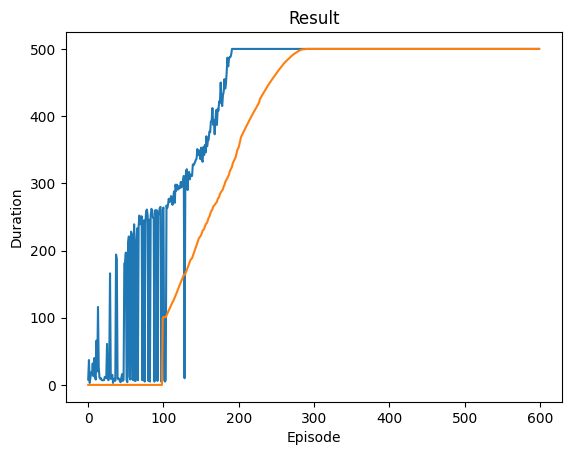

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
BATCH_SIZE = 64
state_dtype = torch.float32
reward_dtype = torch.int16
GAMMA = 0.99
TAU = 0.005
Alpha = 0.1

memory_buffer = Replay_buffer()

total_step = 0
def model_train():
    if len(memory_buffer) <= BATCH_SIZE:
        return 0
    batch = memory_buffer.sample(BATCH_SIZE)  #a list was return, use special * operator to unpack when feeding into function
    #the return value is like [#step1: (state, action, next_state, reward), #step2 ...,] we need to convert them into model-friendly format
    ## state: [#step1, #step2], action: [#1,#2,], ... and for convience, we can capsulate them with names by namedtuple
    batch = Transition_tuple(*zip(*batch))
    #print(batch.state)
    state = torch.tensor(batch.state,dtype = state_dtype)
    next_state = batch.next_state
    reward = torch.tensor(batch.reward, dtype = reward_dtype)

    mask_fun = lambda s: True if s is not None else False   #lambda function defined to check whether it's terminated state
    next_state_mask = list(map(mask_fun, next_state))   #has to be list, rather than tuple
    #print(next_state)
    #print(len(next_state))
    non_zero_next_state = torch.tensor(next_state, dtype = state_dtype)[next_state_mask]   #mannually set the terminated state to [0,0,...]
    next_Q_values = torch.zeros(BATCH_SIZE)

    policy_net.train()
    optimizer.zero_grad()
    current_Q_values = policy_net(state).max(1).values
    with torch.no_grad():
        next_Q_values[next_state_mask] = target_net(non_zero_next_state).max(1).values #by definition of MDP, the rewards of terminated (final) state should be 0
        
    
    #temporal_differential_error = reward + GAMMA*next_Q_values - current_Q_values
    expected_rewards = reward + GAMMA*next_Q_values
    
    loss = criterion(Alpha*current_Q_values, Alpha*expected_rewards)
    loss.backward()

    #print('Loss:{}'.format(loss))
    #print(f'Target Q value:{expected_rewards}, current Q value:{current_Q_values}')
    #print(loss)

    #torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)   #limit the gradient value
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



def train():
    state, _info = env.reset()
    max_cumulated_reward = 0
    for i in range(num_episodes):
    # action generation for replay buffer
        cumulated_reward = 0
        for j in count():
            
            action = action_policy.take_action(Q_estimation = policy_net, state = state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            if terminated == True or truncated:
                next_state = [0. for i in range(env.observation_space.shape[0])]
            #mul_fun = lambda x: x*100
            #state = list(map(mul_fun, state))
            #next_state = list(map(mul_fun, next_state))
            if terminated == True:
                reward = -5  #choose the skewed value for terminate (penalty)
            memory_buffer.push(*[state, action, next_state, reward])

    # batch sampling from memory for model training
            model_train()

            cumulated_reward += reward
            

            if terminated == True or truncated == True:
                state, _info = env.reset()
                if cumulated_reward > max_cumulated_reward:
                    max_cumulated_reward = cumulated_reward
                    torch.save(policy_net, 'DQN{}.pt'.format(i))
                break
            else:
                state = next_state
                
        episode_durations.append(cumulated_reward)
        target_net_state_dict = target_net.state_dict()
        policy_net_parameters = policy_net.state_dict()

        for key in target_net_state_dict.keys():
            target_net_state_dict[key] = policy_net_parameters[key] * TAU + target_net_state_dict[key]*(1-TAU)

        target_net.load_state_dict(target_net_state_dict)
        plot_durations()
        
train()
env.close()
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()
        

In [10]:
print(target_net.layer1.bias[:5])
print(policy_net.layer1.bias[:5])
action_policy.decay_value_update

tensor([ 0.2892, -0.0756,  0.7478,  0.7801,  0.0088], grad_fn=<SliceBackward0>)
tensor([ 0.2897, -0.0751,  0.7448,  0.7726,  0.0072], grad_fn=<SliceBackward0>)


<bound method epsilon_greedy_policy.decay_value_update of <__main__.epsilon_greedy_policy object at 0x0000013A7D40BC50>>

Test

In [ ]:
import time 

#env.render_mode = 'human'
DQN_model = torch.load('DQN_official.pt')
cumulated_rewards = 0

env = gym.make("CartPole-v1", render_mode = 'human')
#env = gym.make('Acrobot-v1', render_mode="human")
state, _ = env.reset()
#env.render()

for j in count():
    #action = action_policy.take_action_policy(policy_net, state, verbose=True)
    action = action_policy.take_action_policy(DQN_model, state)
    next_state, reward, terminated, _, __ = env.step(action)
    print('Action:{} Reward:{} next_state {}'.format(action, reward, next_state))
    if terminated or _ == True:
        print('End! with {} rewards'.format(j))
        break
    else:
        cumulated_rewards += 1
        state = next_state
    if cumulated_rewards >= 80: #can be removed, just for test
        break
    time.sleep(0.1)
env.close()


C:\Users\24573\AppData\Local\Temp\ipykernel_394600\4151375913.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DQN_model = torch.load('DQN599.pt')


Action:0 Reward:1.0 next_state [-0.00340922 -0.14934707  0.00109471  0.2691404 ]
Action:1 Reward:1.0 next_state [-0.00639617  0.04575925  0.00647751 -0.02319707]
Action:0 Reward:1.0 next_state [-0.00548098 -0.149455    0.00601357  0.27152252]
Action:1 Reward:1.0 next_state [-0.00847008  0.04558063  0.01144402 -0.01925764]
Action:0 Reward:1.0 next_state [-0.00755847 -0.14970355  0.01105887  0.27701393]
Action:1 Reward:1.0 next_state [-0.01055254  0.04525889  0.01659915 -0.01216062]
Action:0 Reward:1.0 next_state [-0.00964736 -0.15009713  0.01635594  0.28571296]
Action:1 Reward:1.0 next_state [-0.0126493   0.04478779  0.0220702  -0.00176687]
Action:0 Reward:1.0 next_state [-0.01175355 -0.15064362  0.02203486  0.29779696]
Action:1 Reward:1.0 next_state [-0.01476642  0.04415741  0.0279908   0.01214407]
Action:1 Reward:1.0 next_state [-0.01388327  0.23886698  0.02823368 -0.27157766]
Action:0 Reward:1.0 next_state [-0.00910593  0.04335377  0.02280213  0.02987488]
Action:1 Reward:1.0 next_sta